# IMDB Dataset Text Classification

The following dataset has been taken from HuggingFace's dataset collection in the NLP Text Classification section. Below is the link to the dataset:

https://huggingface.co/datasets/imdb

The goal of this project is to successfuly be able to classify IMDB text reviews as Positive (1) or Negative (0). Because this is a practice notebook, my arbitrary goal will be to reach or exceed a minimum accuracy threshold of 90-95%. To do so, I'll implement a series of experiments using various RNN architectures and embedding techniques, including:

1. Simple RNNs
2. LSTM cells
3. GRU cells
4. Bidirectional LSTMs
5. Conv1D
6. Token embedding
7. Character-level embedding
8. GloVe Embeddings
9. Transfer Learning

Let's get started by importing some libraries that we know we are going to need:

In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import utils, layers, Sequential, losses, optimizers
from keras.layers import LSTM, Bidirectional, GRU, SimpleRNN

In [ ]:
!pip install datasets
from datasets import load_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
df = load_dataset('imdb')
df

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets
train_data, test_data = train_test_split(df['train'], test_size=0.2, random_state=42)

# Access the data
train_text = train_data['text']
train_labels = train_data['label']
test_text = test_data['text']
test_labels = test_data['label']

In [ ]:
len(train_text), len(train_labels), len(test_text), len(test_labels)

(20000, 20000, 5000, 5000)

In [ ]:
train_text[0]

'I borrowed this movie despite its extremely low rating, because I wanted to see how the crew manages to animate the presence of multiple worlds. As a matter of fact, they didn\'t - at least, so its seems. Some cameo appearance cut rather clumsily into the movie - that\'s it, this is what the majority of viewers think. However, the surprise comes at the end, and unfortunately then, when probably most of the viewers have already stopped this movie. I was also astonished when I saw that the Brazilian-Portuguese title of this movie means "Voyage into Death". This is THE spoiler.<br /><br />That this movie is about a young girl who goes ALONE onto this boat (on reasons that are completely unclear), you understand only in the last 5 minutes. When you start the movie with the English title "Haunted Boat" in your head, you clearly think that the cameo appearances of strange figures are the "ghosts". But in reality, this movie is not like most other horror movies told from the distant writer-w

In [ ]:
# Create validation set
split_value = int(len(train_text)*0.75)

training_text = train_text[:split_value]
training_labels = train_labels[:split_value]

val_text = train_text[split_value:]
val_labels = train_labels[split_value:]

In [ ]:
len(training_text), len(training_labels), len(val_text), len(val_labels)

(15000, 15000, 5000, 5000)

In [ ]:
# Make our data more performant using the tf.data API
BATCH_SIZE = 32

train_features_dataset = tf.data.Dataset.from_tensor_slices(training_text)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(training_labels)

val_features_dataset = tf.data.Dataset.from_tensor_slices(val_text)
val_labels_dataset = tf.data.Dataset.from_tensor_slices(val_labels)

test_features_dataset = tf.data.Dataset.from_tensor_slices(test_text)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
val_dataset = tf.data.Dataset.zip((val_features_dataset, val_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
round(sum([len(i.split()) for i in train_text])/len(train_text))

233

In [ ]:
# Let's look at some more examples and decide what kind of preprocessing needs to be done
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 10000
max_sequence_length = 235

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_mode='int',
                                    output_sequence_length=max_sequence_length)

In [ ]:
# create TextVectorizer
text_vectorizer.adapt(training_text)

In [ ]:
# test it out
sample = "This is an example"
text_vectorizer([sample])

<tf.Tensor: shape=(1, 235), dtype=int64, numpy=
array([[ 11,   7,  34, 463,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   

In [ ]:
import random

random = random.choice(training_text)

print(f"Original text:\n {random}\
        \n\n Vectorized version:")
text_vectorizer([random])

Original text:
 This is not a film you can really analyse separately from it's production. The audience became the film-makers to an extent unprecedented in the history of the American film industry; we felt so involved that viewing it becomes like watching the work of a friend. How is it possible to be objective? This is our movie, isn't it? Or is it? There may be nothing more disingenuous than a film-maker who promotes himself as the audience's friend, giving them all the naughty treats that the nannyish critics would deny them. Just look at that prime self-publicist Eli Roth, promising gore-hounds all the viscera missing from literally gutless mainstream horror films, only to churn out a watered down and technically incompetent piece of work like 'Hostel'.<br /><br />David R. Ellis may not have spawned the monster that was the internet response to his film, but he was, quite understandably, quick to engage with it. He took the carnival-huckster school of film-making to a new level, 

<tf.Tensor: shape=(1, 235), dtype=int64, numpy=
array([[  11,    7,   22,    4,   20,   24,   68,   63,    1,    1,   37,
          30,  363,    2,  314,  857,    2,  847,    6,   34, 2773,    1,
           8,    2,  497,    5,    2,  315,   20, 1625,   71,  392,   38,
         561,   12,  760,    9,  446,   39,  145,    2,  163,    5,    4,
         461,   87,    7,    9,  604,    6,   28, 4624,   11,    7,  256,
          18,  205,    9,   42,    7,    9,   48,  191,   28,  153,   53,
           1,   72,    4, 1511,   36,    1,  297,   15,    2, 1053,  461,
         724,   98,   32,    2, 4919, 4158,   12,    2,    1, 1396,   57,
        6430,   98,   41,  161,   31,   12, 2619,    1, 7020, 5965, 2340,
           1,   32,    2,    1,  977,   37, 1202,    1, 2668,  202,  100,
          60,    6,    1,   46,    4,    1,  184,    3, 2281, 4641,  406,
           5,  163,   39,    1,   13,  665, 2433,    1,  191,   22,   26,
        9366,    2, 1019,   12,   14,    2, 3109, 3711,    6,   

In [ ]:
# Peruse vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

print(f"There are {len(words_in_vocab)} in the vocabulary.")
print(f"The top 5 words are: {top_5_words}.")
print(f"The bottom 5 words are: {bottom_5_words}.")

There are 10000 in the vocabulary.
The top 5 words are: ['', '[UNK]', 'the', 'and', 'a'].
The bottom 5 words are: ['competently', 'companions', 'comically', 'coincidentally', 'coherence'].


In [ ]:
# Create an Embedding layer to turn our text into numbers
embedding_layer = tf.keras.layers.Embedding(input_dim=max_tokens,
                                            output_dim=256,
                                            embeddings_initializer="uniform",
                                            input_length=max_sequence_length)

In [ ]:
# Sample our embedding and vectorizer layer jointly
embedding_ex = embedding_layer(text_vectorizer([random]))
embedding_ex

<tf.Tensor: shape=(1, 235, 256), dtype=float32, numpy=
array([[[ 0.00404092,  0.01041197, -0.01799317, ..., -0.04889871,
         -0.03237478,  0.04877139],
        [ 0.01279794,  0.0495635 ,  0.0174335 , ..., -0.0433358 ,
         -0.03332955, -0.0192831 ],
        [-0.00245015, -0.04140745,  0.02354871, ..., -0.02393123,
         -0.04692472, -0.00541071],
        ...,
        [ 0.00709205, -0.01807284,  0.04526837, ...,  0.0177276 ,
          0.0090987 , -0.01656767],
        [ 0.01248135, -0.04909449,  0.00881758, ...,  0.01727766,
         -0.046224  , -0.04047908],
        [ 0.03464557, -0.00987035, -0.04228485, ..., -0.02113438,
          0.04164313, -0.01877679]]], dtype=float32)>

# Starting In on our Modelling Experiments

Before we start, let's create a model evaluation pipeline function to keep track of our models' performance during our various experiments.

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred)*100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1 score": model_f1}
  return model_results

In [ ]:
# Create a baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

naive_model = Pipeline([
    ("tfidf", TfidfVectorizer()),
     ("naive bayes", MultinomialNB())
])

naive_model.fit(training_text, training_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('naive bayes', MultinomialNB())])

In [ ]:
baseline_score = naive_model.score(val_text, val_labels)
baseline_score

0.8626

In [ ]:
baseline_preds = naive_model.predict(val_text)
baseline_preds

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
baseline_results = evaluate_model(val_labels, baseline_preds)
baseline_results

{'accuracy': 86.26,
 'precision': 0.8636746336706282,
 'recall': 0.8626,
 'f1 score': 0.862562419625469}

Pretty good for a baseline, though no quite to our goal of 90-95% or above. Let's model a few different RNN architectures with our basic embedding, before moving onto different embedding styles and transfer learning.

In [ ]:
# Create TensorBoard callback for NNs before startin TF experiments
import datetime

def create_tb_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d, %H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# Create a simple Dense model using the Functional API
TB_LOGS = "nn_model logs"

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding_layer(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = tf.keras.Model(inputs, outputs, name="model1_dense")

model1.compile(loss = losses.BinaryCrossentropy(),
               optimizer = optimizers.Adam(),
               metrics = ['accuracy'])

history1 = model1.fit(train_dataset,
           epochs = 20,
           validation_data=val_dataset,
           callbacks=create_tb_callback(TB_LOGS,
                                        experiment_name=model1.name))

Saving TensorBoard log files to: nn_model logs/model1_dense/20230411, 183750
Epoch 1/20
469/469 [==============================] - 9s 9ms/step - loss: 0.5414 - accuracy: 0.7759 - val_loss: 0.3924 - val_accuracy: 0.8404
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3113 - accuracy: 0.8763 - val_loss: 0.3273 - val_accuracy: 0.8612
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.2182 - accuracy: 0.9211 - val_loss: 0.3089 - val_accuracy: 0.8702
Epoch 4/20
469/469 [==============================] - 4s 9ms/step - loss: 0.1504 - accuracy: 0.9547 - val_loss: 0.3042 - val_accuracy: 0.8706
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0996 - accuracy: 0.9765 - val_loss: 0.3075 - val_accuracy: 0.8728
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0635 - accuracy: 0.9893 - val_loss: 0.3156 - val_accuracy: 0.8732
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - los

In [ ]:
def plot_loss_curves(history):
  
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.grid(False)
  plt.legend()

  # Plot the accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.grid(False)
  plt.legend();

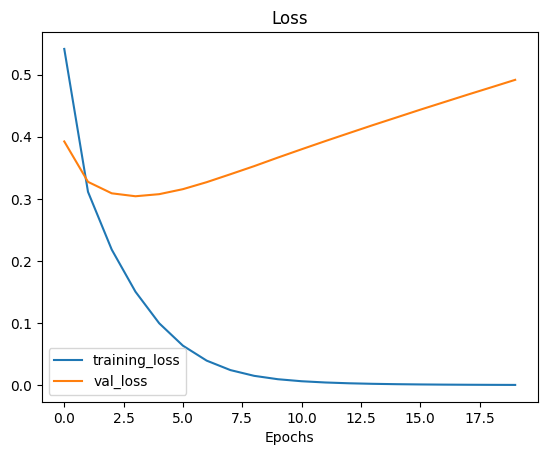

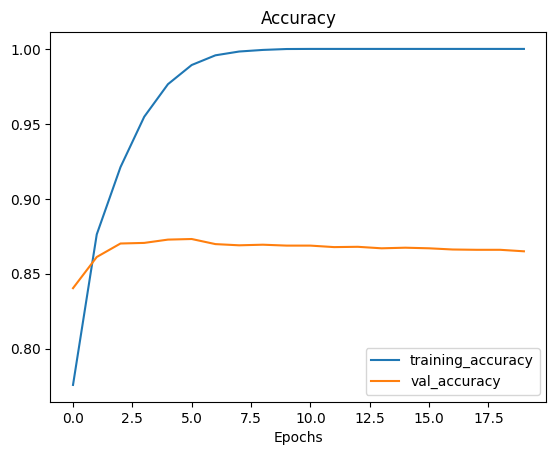

In [ ]:
# Check the loss curves of our Dense model
plot_loss_curves(history1)

In [ ]:
model1_pred_probs = model1.predict(val_text)

model1_preds = tf.round(tf.squeeze(model1_pred_probs))
model1_preds, model1_preds.shape

157/157 [==============================] - 1s 3ms/step


(<tf.Tensor: shape=(5000,), dtype=float32, numpy=array([1., 0., 1., ..., 1., 1., 1.], dtype=float32)>,
 TensorShape([5000]))

In [ ]:
model1_results = evaluate_model(val_labels, model1_preds)
baseline_results, model1_results

({'accuracy': 86.26,
  'precision': 0.8636746336706282,
  'recall': 0.8626,
  'f1 score': 0.862562419625469},
 {'accuracy': 86.5,
  'precision': 0.8650085223466062,
  'recall': 0.865,
  'f1 score': 0.8649889960585566})

The model is clearly overfitting drastically to the training dataset. Let's move on with our experiments for now and see how different model architectures do before making too many changes.

In [ ]:
# Build basic LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding_layer(x)

x = layers.LSTM(64, activation='tanh', return_sequences=True)(x)
x = layers.LSTM(32, activation='tanh')(x)
x = layers.Dense(10, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model2 = tf.keras.Model(inputs, outputs, name="model2_lstm")

model2.compile(loss = losses.BinaryCrossentropy(),
               optimizer = optimizers.Adam(),
               metrics = ['accuracy'])

history2 = model2.fit(train_dataset,
           epochs = 20,
           validation_data=val_dataset,
           callbacks=create_tb_callback(TB_LOGS,
                                        experiment_name=model2.name))

Saving TensorBoard log files to: nn_model logs/model2_lstm/20230411, 183921
Epoch 1/20
469/469 [==============================] - 17s 24ms/step - loss: 0.6925 - accuracy: 0.5131 - val_loss: 0.6916 - val_accuracy: 0.5088
Epoch 2/20
469/469 [==============================] - 10s 21ms/step - loss: 0.6796 - accuracy: 0.5466 - val_loss: 0.6866 - val_accuracy: 0.5362
Epoch 3/20
469/469 [==============================] - 10s 21ms/step - loss: 0.6360 - accuracy: 0.6041 - val_loss: 0.6683 - val_accuracy: 0.6056
Epoch 4/20
469/469 [==============================] - 11s 23ms/step - loss: 0.5448 - accuracy: 0.7211 - val_loss: 0.6916 - val_accuracy: 0.5456
Epoch 5/20
469/469 [==============================] - 10s 22ms/step - loss: 0.4233 - accuracy: 0.8127 - val_loss: 0.5050 - val_accuracy: 0.7858
Epoch 6/20
469/469 [==============================] - 10s 22ms/step - loss: 0.3864 - accuracy: 0.8398 - val_loss: 0.5268 - val_accuracy: 0.7962
Epoch 7/20
469/469 [==============================] - 11s 23

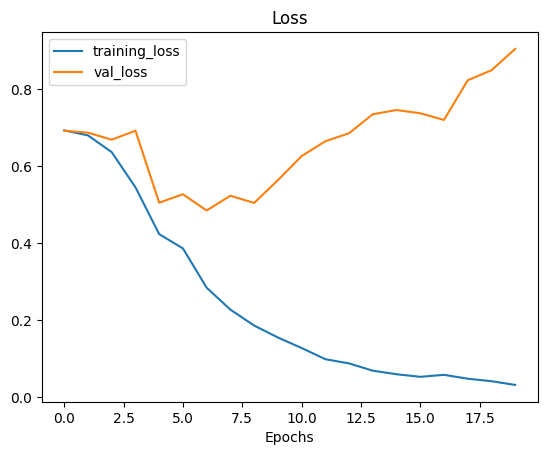

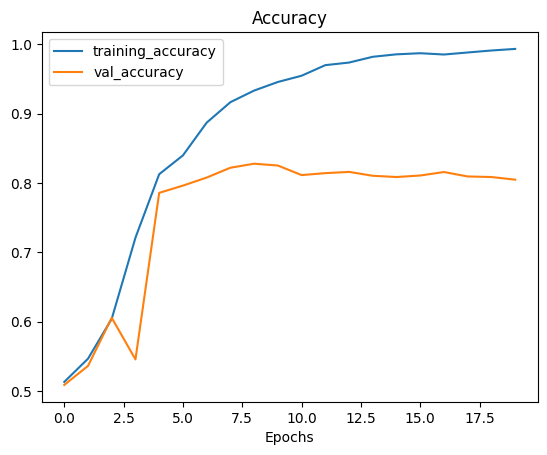

In [ ]:
plot_loss_curves(history2)

In [ ]:
model2_pred_probs = model2.predict(val_text)

157/157 [==============================] - 2s 9ms/step


In [ ]:
model2_preds = tf.round(tf.squeeze(model2_pred_probs))
model2_preds

<tf.Tensor: shape=(5000,), dtype=float32, numpy=array([0., 0., 1., ..., 1., 1., 1.], dtype=float32)>

In [ ]:
# Evaluate the model
model2_results = evaluate_model(val_labels, model2_preds)
model2_results

{'accuracy': 80.47999999999999,
 'precision': 0.8086533946523373,
 'recall': 0.8048,
 'f1 score': 0.8043976382454512}

More or less the same as the Dense model. Nothing in particular to note here. Let's try making the model LSTM cells Bidirectional and try a GRU model as well.

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding_layer(x)

x = layers.Bidirectional(
    layers.LSTM(64, activation='tanh', return_sequences=True))(x)
x = layers.Bidirectional(
    layers.LSTM(64, activation='tanh'))(x)
x = layers.Dense(10, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model3 = tf.keras.Model(inputs, outputs, name="model2_lstm")

model3.compile(loss = losses.BinaryCrossentropy(),
               optimizer = optimizers.Adam(),
               metrics = ['accuracy'])

history3 = model3.fit(train_dataset,
           epochs = 20,
           validation_data=val_dataset,
           callbacks=create_tb_callback(TB_LOGS,
                                        experiment_name=model3.name))

Saving TensorBoard log files to: nn_model logs/model2_lstm/20230411, 184324
Epoch 1/20
469/469 [==============================] - 25s 42ms/step - loss: 0.4319 - accuracy: 0.7865 - val_loss: 0.4520 - val_accuracy: 0.8340
Epoch 2/20
469/469 [==============================] - 18s 39ms/step - loss: 0.1623 - accuracy: 0.9376 - val_loss: 0.5603 - val_accuracy: 0.8332
Epoch 3/20
469/469 [==============================] - 18s 39ms/step - loss: 0.0720 - accuracy: 0.9768 - val_loss: 0.6636 - val_accuracy: 0.8238
Epoch 4/20
469/469 [==============================] - 18s 38ms/step - loss: 0.0422 - accuracy: 0.9885 - val_loss: 0.7949 - val_accuracy: 0.8116
Epoch 5/20
469/469 [==============================] - 18s 39ms/step - loss: 0.0312 - accuracy: 0.9923 - val_loss: 0.8462 - val_accuracy: 0.8088
Epoch 6/20
469/469 [==============================] - 18s 38ms/step - loss: 0.0282 - accuracy: 0.9923 - val_loss: 0.9737 - val_accuracy: 0.8054
Epoch 7/20
469/469 [==============================] - 18s 39

In [ ]:
# Let's functionize the evaluation of our models
def full_model_eval(model):
  pred_probs = model.predict(val_text)
  preds = tf.round(tf.squeeze(pred_probs))
  results = evaluate_model(val_labels, preds)
  return results

In [ ]:
model3_results = full_model_eval(model3)
model3_results

157/157 [==============================] - 4s 15ms/step


{'accuracy': 81.42,
 'precision': 0.8143883754296716,
 'recall': 0.8142,
 'f1 score': 0.814209476036901}

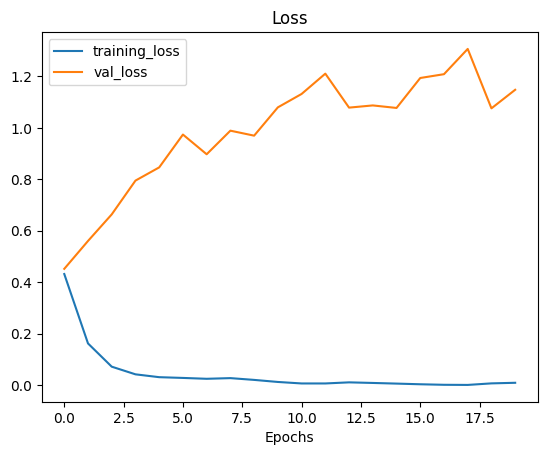

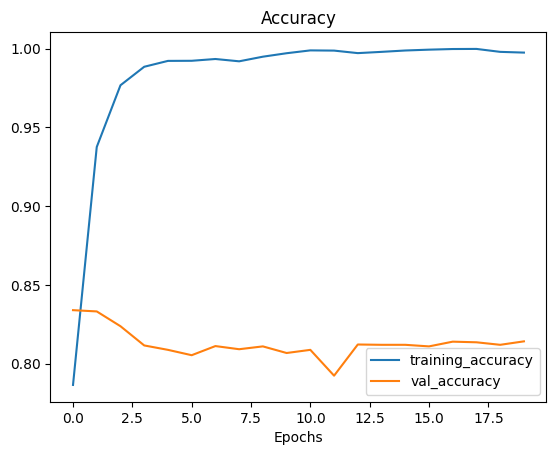

In [ ]:
plot_loss_curves(history3)

In [ ]:
# Let's implement some callbacks to reduce overfitting/address the plateau
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                    factor=0.001,
                                                    patience=3,
                                                    verbose=False)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=5,
                                              verbose=False)

In [ ]:
# GRU model, more Dense + Dropout
act1 = 'tanh'
act2 = 'relu'
act3 = 'sigmoid'

inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding_layer(x)

x = layers.GRU(64, act1, return_sequences=True)(x)
x = layers.GRU(32, act1)(x)

x = layers.Dense(64, act2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, act2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16, act1)(x)
outputs = layers.Dense(1, act3)(x)

model4 = keras.Model(inputs, outputs)

tb = create_tb_callback(TB_LOGS, experiment_name=model4.name)

model4.compile(loss = losses.BinaryCrossentropy(),
               optimizer = optimizers.Adam(),
               metrics=['accuracy'])

history4 = model4.fit(train_dataset,
           epochs = 20,
           validation_data=val_dataset,
           callbacks=[tb, lr_scheduler, reduce_lr_cb, early_stop])

Saving TensorBoard log files to: nn_model logs/model/20230411, 184954
Epoch 1/20
469/469 [==============================] - 15s 25ms/step - loss: 0.5035 - accuracy: 0.7439 - val_loss: 0.6518 - val_accuracy: 0.8054 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 9s 20ms/step - loss: 0.1299 - accuracy: 0.9549 - val_loss: 0.6369 - val_accuracy: 0.8226 - lr: 9.0000e-04
Epoch 3/20
469/469 [==============================] - 10s 21ms/step - loss: 0.0421 - accuracy: 0.9881 - val_loss: 0.8938 - val_accuracy: 0.8046 - lr: 8.1000e-04
Epoch 4/20
469/469 [==============================] - 10s 21ms/step - loss: 0.0161 - accuracy: 0.9960 - val_loss: 1.0088 - val_accuracy: 0.8086 - lr: 7.2900e-04
Epoch 5/20
469/469 [==============================] - 10s 21ms/step - loss: 0.0096 - accuracy: 0.9975 - val_loss: 1.1604 - val_accuracy: 0.8128 - lr: 6.5610e-04
Epoch 6/20
469/469 [==============================] - 10s 21ms/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 1.1776 - val_acc

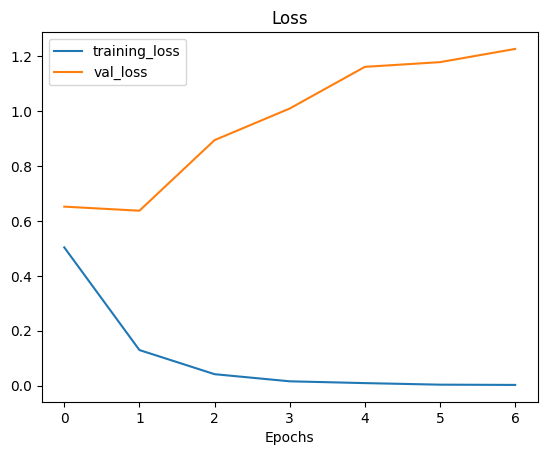

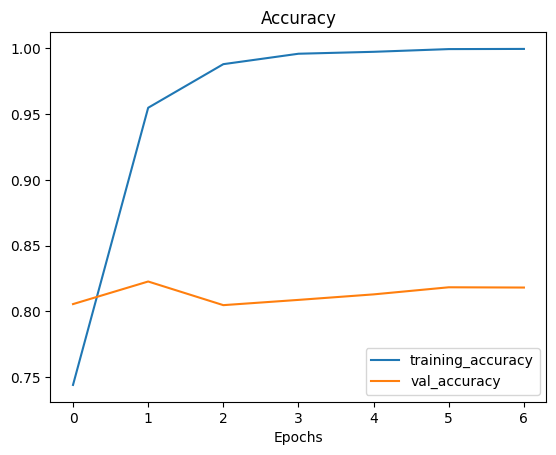

In [ ]:
plot_loss_curves(history4)

In [ ]:
model4_results = full_model_eval(model4)
model4_results

157/157 [==============================] - 2s 9ms/step


{'accuracy': 81.8,
 'precision': 0.8179982198418476,
 'recall': 0.818,
 'f1 score': 0.8179860172453974}

We are still seeing similar results. Just for a sanity check (and because I forgot to do it earlier) let's run a quick test with a SimpleRNN architecture before moving onto various alternative embedding techniques, 1D convolutional models, and transfer learning models.

In [ ]:
# DON'T RUN WHEN RESTARTING NOTEBOOK - PERFORMS POORLY, TAKES FOREVER #

# Results are as follows:
# accuracy: 54.120000000000005
# precision: 0.5607793113488646
# recall: 0.5412
# f1 score: 0.4890401233206021

model5 = Sequential([
    text_vectorizer,
    embedding_layer,
    layers.SimpleRNN(64, return_sequences=True),
    layers.SimpleRNN(64, return_sequences=True),
    layers.SimpleRNN(32),
    layers.Dense(64, 'relu'),
    layers.Dropout(0.5),
    layers.Dense(32, 'relu'),
    layers.Dropout(0.5),
    layers.Dense(16, 'relu'),
    layers.Dense(1, 'sigmoid')
], name="model5_simple_rnn")

tb = create_tb_callback(TB_LOGS, experiment_name=model5.name)

model5.compile(loss = losses.BinaryCrossentropy(),
               optimizer = optimizers.Adam(),
               metrics=['accuracy'])

# history5 = model5.fit(train_dataset,
#            epochs = 20,
#            validation_data=val_dataset,
#            callbacks=[tb, lr_scheduler, reduce_lr_cb, early_stop])

# plot_loss_curves(history5)

# model5_results = full_model_eval(model5)
# model5_results

Saving TensorBoard log files to: nn_model logs/model5_simple_rnn/20230411, 185114


In [ ]:
# Custom swish activation function
class Swish(tf.keras.layers.Layer):
    def __init__(self):
        super(Swish, self).__init__()

    def call(self, inputs):
        return inputs * tf.sigmoid(inputs)

# Custom Mish activation function
class Mish(tf.keras.layers.Layer):
    def __init__(self):
        super(Mish, self).__init__()

    def call(self, inputs):
        return inputs * tf.math.tanh(tf.math.softplus(inputs))

In [ ]:
# Conv1D Model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding_layer(x)

x = layers.Conv1D(32, 5, activation='relu', padding='valid')(x)
x = layers.GlobalAveragePooling1D()(x)

x = layers.Dense(10, activation=Swish())(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model6 = keras.Model(inputs, outputs, name="model6_conv1d")

tb = create_tb_callback(TB_LOGS, experiment_name=model6.name)

model6.compile(loss = losses.BinaryCrossentropy(),
               optimizer = optimizers.Adam(),
               metrics=['accuracy'])

history6 = model6.fit(train_dataset,
           epochs = 20,
           validation_data=val_dataset,
           callbacks=[tb, lr_scheduler, reduce_lr_cb, early_stop])

Saving TensorBoard log files to: nn_model logs/model6_conv1d/20230411, 185114
Epoch 1/20
469/469 [==============================] - 11s 11ms/step - loss: 0.3467 - accuracy: 0.8531 - val_loss: 0.3489 - val_accuracy: 0.8492 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1852 - accuracy: 0.9405 - val_loss: 0.3847 - val_accuracy: 0.8548 - lr: 9.0000e-04
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1229 - accuracy: 0.9625 - val_loss: 0.4625 - val_accuracy: 0.8586 - lr: 8.1000e-04
Epoch 4/20
469/469 [==============================] - 5s 10ms/step - loss: 0.0861 - accuracy: 0.9769 - val_loss: 0.5775 - val_accuracy: 0.8546 - lr: 7.2900e-04
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0604 - accuracy: 0.9859 - val_loss: 0.6678 - val_accuracy: 0.8558 - lr: 6.5610e-04
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0404 - accuracy: 0.9917 - val_loss: 0.8111 - val_acc

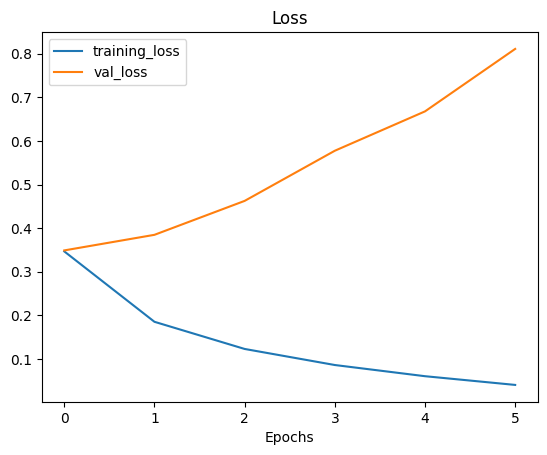

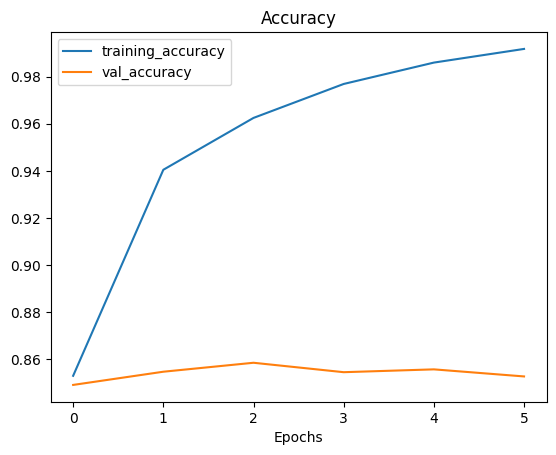

In [ ]:
plot_loss_curves(history6)

In [ ]:
model6_results = full_model_eval(model6)
model6_results

157/157 [==============================] - 1s 5ms/step


{'accuracy': 85.28,
 'precision': 0.8533636745097359,
 'recall': 0.8528,
 'f1 score': 0.852682834994463}

In [ ]:
# Results so far
baseline_results, model1_results, model2_results, model3_results, model4_results, model6_results

({'accuracy': 86.26,
  'precision': 0.8636746336706282,
  'recall': 0.8626,
  'f1 score': 0.862562419625469},
 {'accuracy': 86.5,
  'precision': 0.8650085223466062,
  'recall': 0.865,
  'f1 score': 0.8649889960585566},
 {'accuracy': 80.47999999999999,
  'precision': 0.8086533946523373,
  'recall': 0.8048,
  'f1 score': 0.8043976382454512},
 {'accuracy': 81.42,
  'precision': 0.8143883754296716,
  'recall': 0.8142,
  'f1 score': 0.814209476036901},
 {'accuracy': 81.8,
  'precision': 0.8179982198418476,
  'recall': 0.818,
  'f1 score': 0.8179860172453974},
 {'accuracy': 85.28,
  'precision': 0.8533636745097359,
  'recall': 0.8528,
  'f1 score': 0.852682834994463})

The simple Dense model has performed the best so far, but only marginally and we are not very close to our threshold yet. Let's now start implementing some various embedding techniques and some other, more effective models.

Aside from our baseline and transfer learning experiments, we will only modify our Dense (`model1`) and Conv1D (`model6`) models from here on out in the interest of efficiency.

# Implementing Other Embedding Techniques

### Character-level Embeddings

In [ ]:
train_text[0]

'I borrowed this movie despite its extremely low rating, because I wanted to see how the crew manages to animate the presence of multiple worlds. As a matter of fact, they didn\'t - at least, so its seems. Some cameo appearance cut rather clumsily into the movie - that\'s it, this is what the majority of viewers think. However, the surprise comes at the end, and unfortunately then, when probably most of the viewers have already stopped this movie. I was also astonished when I saw that the Brazilian-Portuguese title of this movie means "Voyage into Death". This is THE spoiler.<br /><br />That this movie is about a young girl who goes ALONE onto this boat (on reasons that are completely unclear), you understand only in the last 5 minutes. When you start the movie with the English title "Haunted Boat" in your head, you clearly think that the cameo appearances of strange figures are the "ghosts". But in reality, this movie is not like most other horror movies told from the distant writer-w

In [ ]:
sample = 'This is a sample sentence'

def split_chars(text):
  return " ".join(list(text))

split_chars(sample)

'T h i s   i s   a   s a m p l e   s e n t e n c e'

In [ ]:
# The function works. Let's split the data in the same way
train_chars = [split_chars(text) for text in training_text]
val_chars = [split_chars(text) for text in val_text]
test_chars = [split_chars(text) for text in val_text]
train_chars[:3]

['I   b o r r o w e d   t h i s   m o v i e   d e s p i t e   i t s   e x t r e m e l y   l o w   r a t i n g ,   b e c a u s e   I   w a n t e d   t o   s e e   h o w   t h e   c r e w   m a n a g e s   t o   a n i m a t e   t h e   p r e s e n c e   o f   m u l t i p l e   w o r l d s .   A s   a   m a t t e r   o f   f a c t ,   t h e y   d i d n \' t   -   a t   l e a s t ,   s o   i t s   s e e m s .   S o m e   c a m e o   a p p e a r a n c e   c u t   r a t h e r   c l u m s i l y   i n t o   t h e   m o v i e   -   t h a t \' s   i t ,   t h i s   i s   w h a t   t h e   m a j o r i t y   o f   v i e w e r s   t h i n k .   H o w e v e r ,   t h e   s u r p r i s e   c o m e s   a t   t h e   e n d ,   a n d   u n f o r t u n a t e l y   t h e n ,   w h e n   p r o b a b l y   m o s t   o f   t h e   v i e w e r s   h a v e   a l r e a d y   s t o p p e d   t h i s   m o v i e .   I   w a s   a l s o   a s t o n i s h e d   w h e n   I   s a w   t h a t   t h e   B r a z i l i 

In [ ]:
# Let's find the average character length in an example
char_len = [len(text) for text in training_text]
mean_chars = np.mean(char_len)
mean_chars

1323.6299333333334

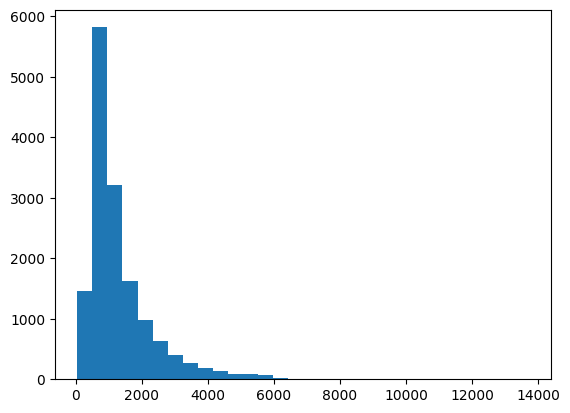

In [ ]:
# Now let's check the distribution of sequences at the character level
plt.hist(char_len, bins=30);

In [ ]:
# What character length covers ~95% of sequences?
out_seq_char_len = int(np.percentile(char_len, 95))
out_seq_char_len

3415

In [ ]:
# Let's save all ASCII characters to a variable
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Time to create our char-level tokenizer instance
NUM_CHARS = len(alphabet) + 2 # <-- for space and OOV tokens
char_vectorizer = TextVectorization(max_tokens=NUM_CHARS,
                                    output_sequence_length=out_seq_char_len,
                                    name="char_vectorizer")

# Adapt to chars, like we did for our vocabulary
char_vectorizer.adapt(train_chars)

In [ ]:
# Check the char stats, like we did with the vocab
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 70
5 most common characters: ['', '[UNK]', 'e', 't', 'a']
5 least common characters: ['\x8e', '\x84', 'ç', '«', 'ê']


In [ ]:
# Test our character vectorizer
import random

random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")

vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 O K   -   t h e   h e l i c o p t e r   s h o t s   a r e   f a n t a s t i c ,   a n d   t h e   d i r e c t o r   m a d e   g o o d   u s e   o f   s o m e   o f   B a r c e l o n a ' s   t o p   s i g h t s .   O t h e r w i s e . . . p r o d u c t i o n   v a l u e   w a s   b l o w n   i n   t h e   f i r s t   f e w   m i n u t e s   a n d   t h e   r e s t   o f   t h e   f i l m   f e l t   l i k e   a   m o v i e   o f   t h e   w e e k .   E l l e n   P o m p e o   w a s   c h a r m i n g   a n d   f u n   t o   w a t c h ,   A b e l   F o l k   h a d   t h e   m o s t   d e p t h   a n d   w a s   v e r y   e f f e c t i v e ,   a n d   W i l l i a m   B a l d w i n   w a s . . . w e l l ,   W i l l i a m   B a l d w i n .   H e   g o t   t o   p u t   h i s   m a r t i a l   a r t   t r a i n i n g   t o   g o o d   u s e   a n d   b e   a   r u n n i n g - j u m p i n g - e a r n e s t   a c t i o n   f i g u r e .   T h e   r e s t   o f   t h e   c a s t

In [ ]:
# Create a character level embedding layer and test
char_embedding = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                           output_dim=32,
                                           mask_zero=True,
                                           name="char_embed")

# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
print(f"Embedded chars after vectorization and embedding:\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 O K   -   t h e   h e l i c o p t e r   s h o t s   a r e   f a n t a s t i c ,   a n d   t h e   d i r e c t o r   m a d e   g o o d   u s e   o f   s o m e   o f   B a r c e l o n a ' s   t o p   s i g h t s .   O t h e r w i s e . . . p r o d u c t i o n   v a l u e   w a s   b l o w n   i n   t h e   f i r s t   f e w   m i n u t e s   a n d   t h e   r e s t   o f   t h e   f i l m   f e l t   l i k e   a   m o v i e   o f   t h e   w e e k .   E l l e n   P o m p e o   w a s   c h a r m i n g   a n d   f u n   t o   w a t c h ,   A b e l   F o l k   h a d   t h e   m o s t   d e p t h   a n d   w a s   v e r y   e f f e c t i v e ,   a n d   W i l l i a m   B a l d w i n   w a s . . . w e l l ,   W i l l i a m   B a l d w i n .   H e   g o t   t o   p u t   h i s   m a r t i a l   a r t   t r a i n i n g   t o   g o o d   u s e   a n d   b e   a   r u n n i n g - j u m p i n g - e a r n e s t   a c t i o n   f i g u r e .   T h e   r e s t   o f   t h e   c a s t

In [ ]:
# Let's rebuild the Dense model (as model7) but with char embeddings
inputs = layers.Input(shape=(1,), dtype='string')
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model7 = tf.keras.Model(inputs, outputs, name="model7_dense_char")

model7.compile(loss = losses.BinaryCrossentropy(),
               optimizer = optimizers.Adam(),
               metrics = ['accuracy'])

tb = create_tb_callback(TB_LOGS, experiment_name=model7.name)

Saving TensorBoard log files to: nn_model logs/model7_dense_char/20230411, 185153


In [ ]:
len(train_chars), len(val_chars)

(15000, 5000)

In [ ]:
# Create a new char-level tf.data.Dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, training_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
history7 = model7.fit(train_char_dataset,
           epochs = 20,
           validation_data=val_char_dataset,
           callbacks=[tb, lr_scheduler, early_stop, reduce_lr_cb])

Epoch 1/20
469/469 [==============================] - 8s 15ms/step - loss: 0.6927 - accuracy: 0.5107 - val_loss: 0.6912 - val_accuracy: 0.5464 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 6s 13ms/step - loss: 0.6908 - accuracy: 0.5319 - val_loss: 0.6898 - val_accuracy: 0.5464 - lr: 9.0000e-04
Epoch 3/20
469/469 [==============================] - 6s 13ms/step - loss: 0.6899 - accuracy: 0.5351 - val_loss: 0.6891 - val_accuracy: 0.5460 - lr: 8.1000e-04
Epoch 4/20
469/469 [==============================] - 5s 12ms/step - loss: 0.6894 - accuracy: 0.5389 - val_loss: 0.6889 - val_accuracy: 0.5464 - lr: 7.2900e-04
Epoch 5/20
469/469 [==============================] - 6s 12ms/step - loss: 0.6886 - accuracy: 0.5396 - val_loss: 0.6879 - val_accuracy: 0.5488 - lr: 6.5610e-04
Epoch 6/20
469/469 [==============================] - 6s 13ms/step - loss: 0.6876 - accuracy: 0.5417 - val_loss: 0.6871 - val_accuracy: 0.5510 - lr: 5.9049e-04
Epoch 7/20
469/469 [========================

157/157 [==============================] - 1s 6ms/step


{'accuracy': 50.019999999999996,
 'precision': 0.5220981604694184,
 'recall': 0.5002,
 'f1 score': 0.3953414338463856}

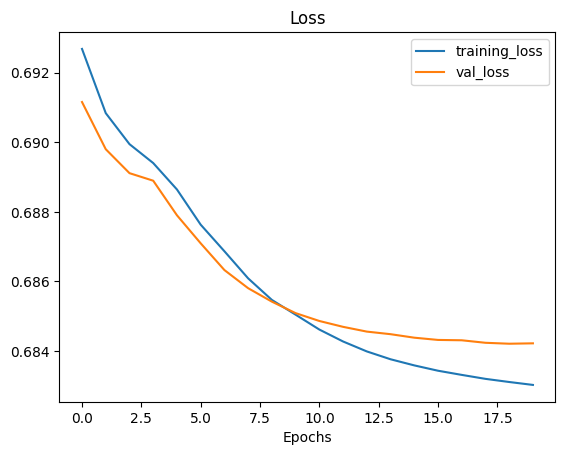

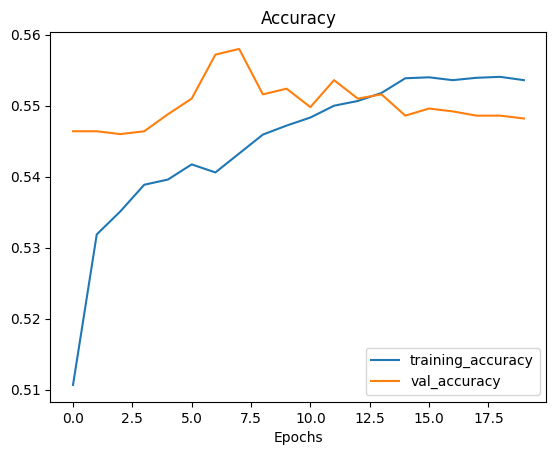

In [ ]:
plot_loss_curves(history7)
full_model_eval(model7)

Although the shape of the curves seems to be less erratic than some of the past experiments, the accuracy is just not very good. Let's try one more Dense architecture and a couple CNN architectures before incorporating GloVe embeddings, too.

In [ ]:
# Another Dense architecture with different activation and more nodes
inputs = layers.Input(shape=(1,), dtype='string')
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(10, activation=Mish())(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, 'sigmoid')(x)

model9 = tf.keras.Model(inputs, outputs, name="model9_mish_char")

model9.compile(loss = losses.BinaryCrossentropy(),
               optimizer = optimizers.Adam(),
               metrics = ['accuracy'])

tb9 = create_tb_callback(TB_LOGS, experiment_name=model9.name)

Saving TensorBoard log files to: nn_model logs/model9_mish_char/20230411, 185405


Epoch 1/20
469/469 [==============================] - 6s 12ms/step - loss: 0.6896 - accuracy: 0.5338 - val_loss: 0.6866 - val_accuracy: 0.5474 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 6s 13ms/step - loss: 0.6851 - accuracy: 0.5480 - val_loss: 0.6845 - val_accuracy: 0.5474 - lr: 9.0000e-04
Epoch 3/20
469/469 [==============================] - 6s 12ms/step - loss: 0.6837 - accuracy: 0.5520 - val_loss: 0.6842 - val_accuracy: 0.5510 - lr: 8.1000e-04
Epoch 4/20
469/469 [==============================] - 6s 13ms/step - loss: 0.6839 - accuracy: 0.5525 - val_loss: 0.6840 - val_accuracy: 0.5510 - lr: 7.2900e-04
Epoch 5/20
469/469 [==============================] - 5s 12ms/step - loss: 0.6825 - accuracy: 0.5562 - val_loss: 0.6839 - val_accuracy: 0.5506 - lr: 6.5610e-04
Epoch 6/20
469/469 [==============================] - 7s 15ms/step - loss: 0.6836 - accuracy: 0.5539 - val_loss: 0.6838 - val_accuracy: 0.5486 - lr: 5.9049e-04
Epoch 7/20
469/469 [========================

{'accuracy': 50.4,
 'precision': 0.5369782906089895,
 'recall': 0.504,
 'f1 score': 0.3971463132347021}

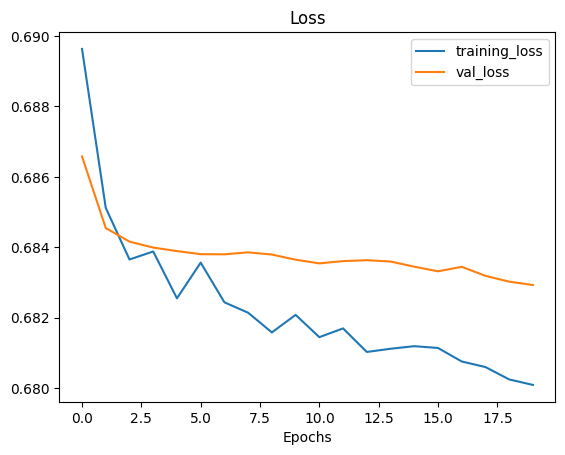

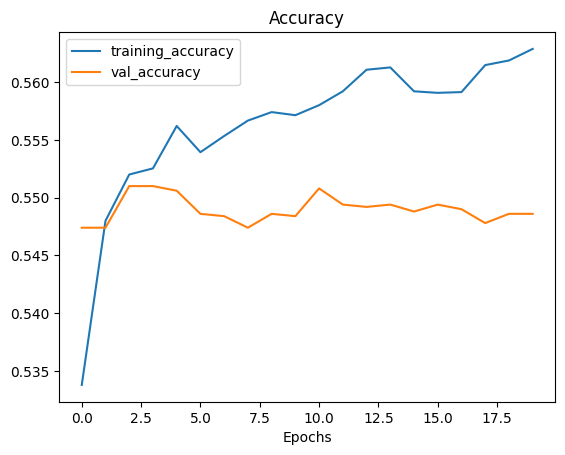

In [ ]:
history9 = model9.fit(train_char_dataset,
           epochs = 20,
           validation_data=val_char_dataset,
           callbacks=[tb9, lr_scheduler, early_stop, reduce_lr_cb])

plot_loss_curves(history9)
full_model_eval(model9)

In [ ]:
# Recreate previous CNN arch as model8
inputs = layers.Input(shape=(1,), dtype="string")
x = char_vectorizer(inputs)
x = char_embedding(x)

x = layers.Conv1D(32, 5, padding="valid", activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)

x = layers.Dense(10, activation=Swish())(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, 'sigmoid')(x)

model8 = keras.Model(inputs, outputs, name="model8_conv_char")

model8.compile(loss=losses.BinaryCrossentropy(),
               optimizer=optimizers.Adam(),
               metrics=['accuracy'])

tb8 = create_tb_callback(TB_LOGS, model8.name)

history8 = model8.fit(train_char_dataset,
           epochs = 20,
           validation_data=val_char_dataset,
           callbacks=[tb, lr_scheduler, early_stop, reduce_lr_cb])

Saving TensorBoard log files to: nn_model logs/model8_conv_char/20230411, 185620
Epoch 1/20
469/469 [==============================] - 7s 12ms/step - loss: 0.6935 - accuracy: 0.4948 - val_loss: 0.6931 - val_accuracy: 0.4978 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 6s 12ms/step - loss: 0.6930 - accuracy: 0.5080 - val_loss: 0.6914 - val_accuracy: 0.5154 - lr: 9.0000e-04
Epoch 3/20
469/469 [==============================] - 6s 13ms/step - loss: 0.6913 - accuracy: 0.5205 - val_loss: 0.6878 - val_accuracy: 0.5246 - lr: 8.1000e-04
Epoch 4/20
469/469 [==============================] - 5s 12ms/step - loss: 0.6833 - accuracy: 0.5655 - val_loss: 0.6791 - val_accuracy: 0.5636 - lr: 7.2900e-04
Epoch 5/20
469/469 [==============================] - 6s 13ms/step - loss: 0.6713 - accuracy: 0.5968 - val_loss: 0.6752 - val_accuracy: 0.5754 - lr: 6.5610e-04
Epoch 6/20
469/469 [==============================] - 6s 12ms/step - loss: 0.6643 - accuracy: 0.6093 - val_loss: 0.6662 - v

157/157 [==============================] - 1s 5ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 50.760000000000005,
 'precision': 0.25765776,
 'recall': 0.5076,
 'f1 score': 0.3418118333775537}

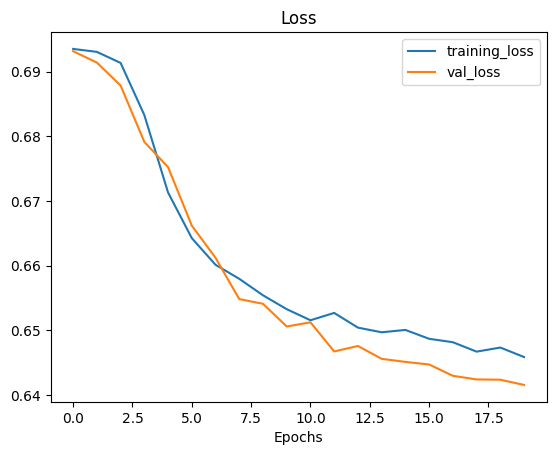

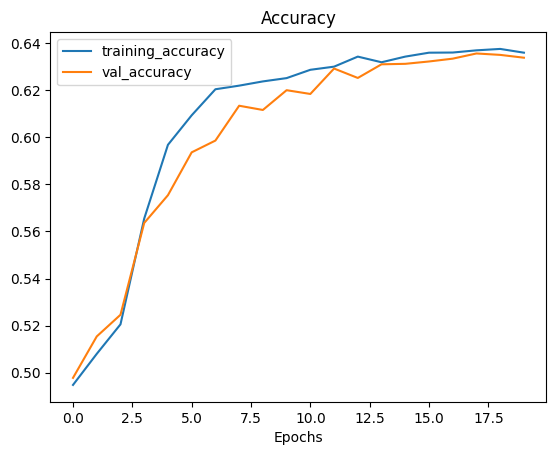

In [ ]:
plot_loss_curves(history8)
full_model_eval(model8)

Even with the curves converging together better, our accuracy is still just not good enough. It doesn't seem like the character level embeddings are helping.

Let's incorporate the GloVe embeddings and do a couple more experiments:

1. Testing Dense and CNN architectures with *just* GloVe embeddings, and
2. Testing Dense and CNN architectures with Glove *and* char-level embeddings.

This should give us an idea of how best to move forward. Of course, a transfer learning experiment is likely to blow all of these out of the water. But this is all for practice, after all :)

# GloVe Embeddings

In [ ]:
# Download pretrained GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-04-11 18:58:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-11 18:58:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-11 18:58:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Create dictionary mapping words to their numpy vector representations
path2glove = "glove.6B.100d.txt"

In [ ]:
embeddings_index = {}

with open(path2glove) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Prepare corresponding embedding matrix to be used in embedding layer
new_output_seq_len = 100

# Let's up the max_tokens this time, too
max_tokens = 50000

# New TextVec instance
glove_vectorizer = TextVectorization(max_tokens=max_tokens,
                                     output_sequence_length=new_output_seq_len)

glove_vectorizer.adapt(training_text)

In [ ]:
# Get new vocab
glove_vocab = glove_vectorizer.get_vocabulary()
glove_vocab[:100]

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'for',
 'with',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'are',
 'you',
 'his',
 'have',
 'he',
 'be',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'who',
 'from',
 'so',
 'like',
 'her',
 'just',
 'or',
 'about',
 'has',
 'if',
 'out',
 'some',
 'there',
 'what',
 'good',
 'when',
 'very',
 'more',
 'she',
 'my',
 'even',
 'would',
 'no',
 'up',
 'only',
 'time',
 'which',
 'really',
 'story',
 'see',
 'their',
 'had',
 'can',
 'were',
 'me',
 'we',
 'than',
 'much',
 'well',
 'been',
 'get',
 'also',
 'people',
 'because',
 'into',
 'will',
 'first',
 'do',
 'other',
 'great',
 'bad',
 'how',
 'most',
 'dont',
 'him',
 'made',
 'movies',
 'then',
 'any',
 'after',
 'way',
 'make',
 'them',
 'could']

In [ ]:
glove_index = dict(zip(range(len(glove_vocab)), glove_vocab))
glove_index.items()

dict_items([(0, ''), (1, '[UNK]'), (2, 'the'), (3, 'and'), (4, 'a'), (5, 'of'), (6, 'to'), (7, 'is'), (8, 'in'), (9, 'it'), (10, 'i'), (11, 'this'), (12, 'that'), (13, 'br'), (14, 'was'), (15, 'as'), (16, 'for'), (17, 'with'), (18, 'movie'), (19, 'but'), (20, 'film'), (21, 'on'), (22, 'not'), (23, 'are'), (24, 'you'), (25, 'his'), (26, 'have'), (27, 'he'), (28, 'be'), (29, 'one'), (30, 'its'), (31, 'at'), (32, 'all'), (33, 'by'), (34, 'an'), (35, 'they'), (36, 'who'), (37, 'from'), (38, 'so'), (39, 'like'), (40, 'her'), (41, 'just'), (42, 'or'), (43, 'about'), (44, 'has'), (45, 'if'), (46, 'out'), (47, 'some'), (48, 'there'), (49, 'what'), (50, 'good'), (51, 'when'), (52, 'very'), (53, 'more'), (54, 'she'), (55, 'my'), (56, 'even'), (57, 'would'), (58, 'no'), (59, 'up'), (60, 'only'), (61, 'time'), (62, 'which'), (63, 'really'), (64, 'story'), (65, 'see'), (66, 'their'), (67, 'had'), (68, 'can'), (69, 'were'), (70, 'me'), (71, 'we'), (72, 'than'), (73, 'much'), (74, 'well'), (75, 'been

In [ ]:
# Prepare embedding matrix
embedding_matrix = np.zeros((len(glove_vocab), new_output_seq_len))
for i, word in glove_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix[:10]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [ ]:
training_text[0]

'I borrowed this movie despite its extremely low rating, because I wanted to see how the crew manages to animate the presence of multiple worlds. As a matter of fact, they didn\'t - at least, so its seems. Some cameo appearance cut rather clumsily into the movie - that\'s it, this is what the majority of viewers think. However, the surprise comes at the end, and unfortunately then, when probably most of the viewers have already stopped this movie. I was also astonished when I saw that the Brazilian-Portuguese title of this movie means "Voyage into Death". This is THE spoiler.<br /><br />That this movie is about a young girl who goes ALONE onto this boat (on reasons that are completely unclear), you understand only in the last 5 minutes. When you start the movie with the English title "Haunted Boat" in your head, you clearly think that the cameo appearances of strange figures are the "ghosts". But in reality, this movie is not like most other horror movies told from the distant writer-w

In [ ]:
glove_embed_layer = layers.Embedding(input_dim=len(glove_vocab),
                                     output_dim=256,
                                     mask_zero=True,
                                     input_length=max_sequence_length)

In [ ]:
# Model10 Dense with just GloVe embeddings
inputs = layers.Input(shape=(1,), dtype="string")
x = glove_vectorizer(inputs)
x = glove_embed_layer(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(10, Swish())(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, 'sigmoid')(x)

model10 = keras.Model(inputs, outputs)

model10.compile(loss = losses.BinaryCrossentropy(),
                optimizer = optimizers.Adam(),
                metrics=['accuracy'])

tb10 = create_tb_callback(TB_LOGS, model10.name)

history10 = model10.fit(train_dataset,
           epochs = 20,
           validation_data=val_dataset,
           callbacks=[tb, lr_scheduler, early_stop, reduce_lr_cb])

Saving TensorBoard log files to: nn_model logs/model_1/20230411, 190147
Epoch 1/20
469/469 [==============================] - 6s 12ms/step - loss: 0.5093 - accuracy: 0.7602 - val_loss: 0.3773 - val_accuracy: 0.8286 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 6s 13ms/step - loss: 0.2588 - accuracy: 0.8995 - val_loss: 0.3848 - val_accuracy: 0.8318 - lr: 9.0000e-04
Epoch 3/20
469/469 [==============================] - 6s 12ms/step - loss: 0.1397 - accuracy: 0.9549 - val_loss: 0.4639 - val_accuracy: 0.8218 - lr: 8.1000e-04
Epoch 4/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0695 - accuracy: 0.9822 - val_loss: 0.5703 - val_accuracy: 0.8184 - lr: 7.2900e-04
Epoch 5/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0316 - accuracy: 0.9941 - val_loss: 0.6771 - val_accuracy: 0.8184 - lr: 6.5610e-04
Epoch 6/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0160 - accuracy: 0.9978 - val_loss: 0.7626 - val_accura

157/157 [==============================] - 1s 3ms/step


{'accuracy': 81.62,
 'precision': 0.8162279379441497,
 'recall': 0.8162,
 'f1 score': 0.8161692455798724}

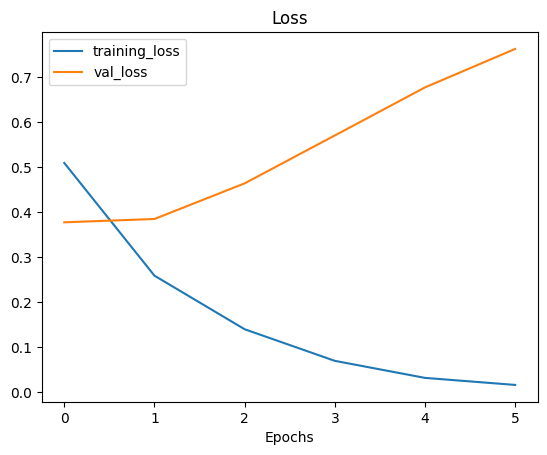

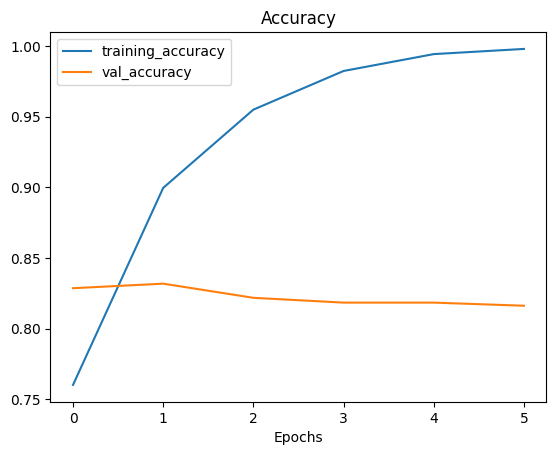

In [ ]:
plot_loss_curves(history10)
full_model_eval(model10)

Better on the accuracy, but we are still overfitting quite a bit. A couple more Dense models to try combating this manually before GloVe CNNs and a hybrid embedding attempt.

Also, before moving on, let's extract the best learning rate so far from this last experiment and get rid of the learning rate schedule callback.

Text(0.5, 1.0, 'Find the Ideal LR')

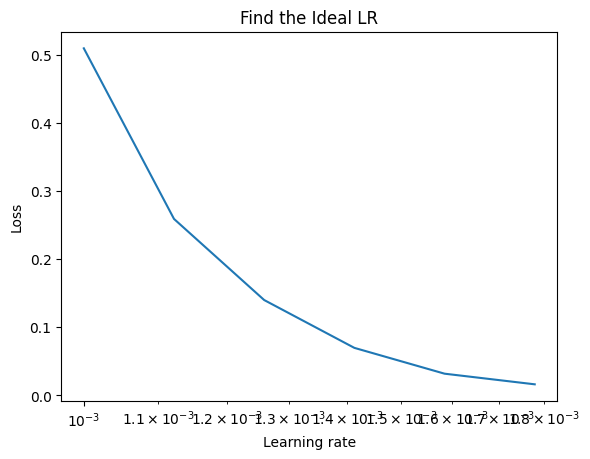

In [ ]:
lrs = 1e-3 * 10**(tf.range(6)/20)
plt.semilogx(lrs, history10.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Find the Ideal LR")

Looks to be about 0.0011. Let's go with that for now.

In [ ]:
# Model 11 Dense with just GloVe embeddings + some hyperparam tweaks
inputs = layers.Input(shape=(1,), dtype="string")
x = glove_vectorizer(inputs)
x = glove_embed_layer(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(100, Swish())(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(10, Swish())(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, 'sigmoid')(x)

model11 = keras.Model(inputs, outputs)

model11.compile(loss = losses.BinaryCrossentropy(),
                optimizer = optimizers.Adam(learning_rate=0.0011),
                metrics=['accuracy'])

tb11 = create_tb_callback(TB_LOGS, model11.name)

history11 = model11.fit(train_dataset,
           epochs = 20,
           validation_data=val_dataset,
           callbacks=[tb11, early_stop, reduce_lr_cb])

Saving TensorBoard log files to: nn_model logs/model_2/20230411, 190229
Epoch 1/20
469/469 [==============================] - 7s 14ms/step - loss: 0.1049 - accuracy: 0.9821 - val_loss: 0.9822 - val_accuracy: 0.8114 - lr: 0.0011
Epoch 2/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0104 - accuracy: 0.9968 - val_loss: 1.3123 - val_accuracy: 0.8072 - lr: 0.0011
Epoch 3/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 1.5508 - val_accuracy: 0.7998 - lr: 0.0011
Epoch 4/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0068 - accuracy: 0.9977 - val_loss: 1.5961 - val_accuracy: 0.8056 - lr: 0.0011
Epoch 5/20
469/469 [==============================] - 6s 14ms/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 1.5846 - val_accuracy: 0.8082 - lr: 1.1000e-06
Epoch 6/20
469/469 [==============================] - 6s 12ms/step - loss: 0.0085 - accuracy: 0.9968 - val_loss: 1.5763 - val_accuracy: 0.8082 -

In [ ]:
# Model12 Dense with Mish activation, less Dense nodes, and less epochs
inputs = layers.Input(shape=(1,), dtype="string")
x = glove_vectorizer(inputs)
x = glove_embed_layer(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(10, Mish())(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, 'sigmoid')(x)

model12 = keras.Model(inputs, outputs)

model12.compile(loss = losses.BinaryCrossentropy(),
                optimizer = optimizers.Adam(learning_rate=0.0011),
                metrics=['accuracy'])

tb12 = create_tb_callback(TB_LOGS, model12.name)

history12 = model12.fit(train_dataset,
           epochs = 10,
           validation_data=val_dataset,
           callbacks=[tb12, early_stop, reduce_lr_cb])

Saving TensorBoard log files to: nn_model logs/model_3/20230411, 190309
Epoch 1/10
469/469 [==============================] - 7s 13ms/step - loss: 0.2665 - accuracy: 0.9478 - val_loss: 0.4482 - val_accuracy: 0.8248 - lr: 0.0011
Epoch 2/10
469/469 [==============================] - 5s 12ms/step - loss: 0.0594 - accuracy: 0.9883 - val_loss: 0.6188 - val_accuracy: 0.8164 - lr: 0.0011
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0254 - accuracy: 0.9981 - val_loss: 0.7866 - val_accuracy: 0.8122 - lr: 0.0011
Epoch 4/10
469/469 [==============================] - 6s 14ms/step - loss: 0.0157 - accuracy: 0.9987 - val_loss: 0.9080 - val_accuracy: 0.8152 - lr: 0.0011
Epoch 5/10
469/469 [==============================] - 5s 12ms/step - loss: 0.0127 - accuracy: 0.9993 - val_loss: 0.9065 - val_accuracy: 0.8152 - lr: 1.1000e-06
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0131 - accuracy: 0.9994 - val_loss: 0.9051 - val_accuracy: 0.8158 -

Not much better. Let's try out trusty `relu` activation for a quick sanity check.

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
x = glove_vectorizer(inputs)
x = glove_embed_layer(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(10, 'relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, 'sigmoid')(x)

model13 = keras.Model(inputs, outputs)

model13.compile(loss = losses.BinaryCrossentropy(),
                optimizer = optimizers.Adam(),
                metrics=['accuracy'])

tb13 = create_tb_callback(TB_LOGS, model13.name)

history13 = model13.fit(train_dataset,
           epochs = 15,
           validation_data=val_dataset,
           callbacks=[tb13, early_stop, reduce_lr_cb])

Saving TensorBoard log files to: nn_model logs/model_4/20230411, 190353
Epoch 1/15
469/469 [==============================] - 6s 12ms/step - loss: 0.2974 - accuracy: 0.9107 - val_loss: 0.3956 - val_accuracy: 0.8262 - lr: 0.0010
Epoch 2/15
469/469 [==============================] - 6s 13ms/step - loss: 0.1167 - accuracy: 0.9442 - val_loss: 0.4973 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 3/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0833 - accuracy: 0.9533 - val_loss: 0.5953 - val_accuracy: 0.8158 - lr: 0.0010
Epoch 4/15
469/469 [==============================] - 5s 12ms/step - loss: 0.0750 - accuracy: 0.9509 - val_loss: 0.6881 - val_accuracy: 0.8132 - lr: 0.0010
Epoch 5/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0720 - accuracy: 0.9529 - val_loss: 0.6869 - val_accuracy: 0.8140 - lr: 1.0000e-06
Epoch 6/15
469/469 [==============================] - 5s 12ms/step - loss: 0.0738 - accuracy: 0.9535 - val_loss: 0.6858 - val_accuracy: 0.8140 -

Not much better. Moving on...

In [ ]:
# Model14 --> original best-performing CNN architecture with just glove embeddings
inputs = layers.Input(shape=(1,), dtype="string")
x = glove_vectorizer(inputs)
x = glove_embed_layer(x)

x = layers.Conv1D(32, 5, activation='relu', padding='valid')(x)
x = layers.GlobalAveragePooling1D()(x)

x = layers.Dense(10, activation=Swish())(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model14 = keras.Model(inputs, outputs, name="model14_glove_conv1d")

tb14 = create_tb_callback(TB_LOGS, experiment_name=model14.name)

model14.compile(loss = losses.BinaryCrossentropy(),
               optimizer = optimizers.Adam(learning_rate=0.0011),
               metrics=['accuracy'])

Saving TensorBoard log files to: nn_model logs/model14_glove_conv1d/20230411, 190433


In [ ]:
history14 = model14.fit(train_dataset,
           epochs = 15,
           validation_data=val_dataset,
           callbacks=[tb14, early_stop, reduce_lr_cb])

Epoch 1/15
469/469 [==============================] - 7s 14ms/step - loss: 0.0981 - accuracy: 0.9770 - val_loss: 1.0203 - val_accuracy: 0.8036 - lr: 0.0011
Epoch 2/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0291 - accuracy: 0.9959 - val_loss: 1.2929 - val_accuracy: 0.7988 - lr: 0.0011
Epoch 3/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0196 - accuracy: 0.9965 - val_loss: 1.3511 - val_accuracy: 0.7890 - lr: 0.0011
Epoch 4/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0158 - accuracy: 0.9963 - val_loss: 1.5952 - val_accuracy: 0.7960 - lr: 0.0011
Epoch 5/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0160 - accuracy: 0.9957 - val_loss: 1.5968 - val_accuracy: 0.7972 - lr: 1.1000e-06
Epoch 6/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0153 - accuracy: 0.9961 - val_loss: 1.6000 - val_accuracy: 0.7980 - lr: 1.1000e-06


In [ ]:
# Model15 --> add filters, change to tanh activation
inputs = layers.Input(shape=(1,), dtype="string")
x = glove_vectorizer(inputs)
x = glove_embed_layer(x)

x = layers.Conv1D(64, 5, activation='tanh', padding='valid')(x)
x = layers.GlobalAveragePooling1D()(x)

x = layers.Dense(10, activation=Swish())(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model15 = keras.Model(inputs, outputs, name="model15_glove_conv1d")

tb15 = create_tb_callback(TB_LOGS, experiment_name=model15.name)

model15.compile(loss = losses.BinaryCrossentropy(),
               optimizer = optimizers.Adam(learning_rate=0.0011),
               metrics=['accuracy'])

history15 = model15.fit(train_dataset,
           epochs = 15,
           validation_data=val_dataset,
           callbacks=[tb15, early_stop, reduce_lr_cb])

Saving TensorBoard log files to: nn_model logs/model15_glove_conv1d/20230411, 190520
Epoch 1/15
469/469 [==============================] - 7s 13ms/step - loss: 0.1268 - accuracy: 0.9845 - val_loss: 0.7714 - val_accuracy: 0.8012 - lr: 0.0011
Epoch 2/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0470 - accuracy: 0.9970 - val_loss: 1.0361 - val_accuracy: 0.7922 - lr: 0.0011
Epoch 3/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0262 - accuracy: 0.9987 - val_loss: 1.0815 - val_accuracy: 0.7990 - lr: 0.0011
Epoch 4/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0173 - accuracy: 0.9987 - val_loss: 1.4064 - val_accuracy: 0.7886 - lr: 0.0011
Epoch 5/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0139 - accuracy: 0.9988 - val_loss: 1.3884 - val_accuracy: 0.7898 - lr: 1.1000e-06
Epoch 6/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0142 - accuracy: 0.9987 - val_loss: 1.3746 - val_accur

In [ ]:
# Model16 --> change activation again
inputs = layers.Input(shape=(1,), dtype="string")
x = glove_vectorizer(inputs)
x = glove_embed_layer(x)

x = layers.Conv1D(64, 5, activation=Swish(), padding='valid')(x)
x = layers.GlobalAveragePooling1D()(x)

x = layers.Dense(10, activation=Swish())(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model16 = keras.Model(inputs, outputs, name="model16_glove_conv1d")

tb16 = create_tb_callback(TB_LOGS, experiment_name=model16.name)

model16.compile(loss = losses.BinaryCrossentropy(),
               optimizer = optimizers.Adam(learning_rate=0.0011),
               metrics=['accuracy'])

history16 = model16.fit(train_dataset,
           epochs = 15,
           validation_data=val_dataset,
           callbacks=[tb16, early_stop, reduce_lr_cb])

Saving TensorBoard log files to: nn_model logs/model16_glove_conv1d/20230411, 190601
Epoch 1/15
469/469 [==============================] - 7s 14ms/step - loss: 0.0440 - accuracy: 0.9949 - val_loss: 1.4245 - val_accuracy: 0.7936 - lr: 0.0011
Epoch 2/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0157 - accuracy: 0.9983 - val_loss: 1.6288 - val_accuracy: 0.7966 - lr: 0.0011
Epoch 3/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0164 - accuracy: 0.9989 - val_loss: 1.8320 - val_accuracy: 0.7936 - lr: 0.0011
Epoch 4/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0125 - accuracy: 0.9991 - val_loss: 1.8605 - val_accuracy: 0.7872 - lr: 0.0011
Epoch 5/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0137 - accuracy: 0.9995 - val_loss: 1.8509 - val_accuracy: 0.7880 - lr: 1.1000e-06
Epoch 6/15
469/469 [==============================] - 6s 12ms/step - loss: 0.0135 - accuracy: 0.9991 - val_loss: 1.8403 - val_accur

One last experiment with MaxPooling layers and extra Conv1D layers. Changing Conv layers to `tanh` activation, Dense to classic `relu`.

In [ ]:
# Model17 --> expanded Conv1D with MaxPooling
inputs = layers.Input(shape=(1,), dtype='string')
x = glove_vectorizer(inputs)
x = glove_embed_layer(x)

x = layers.Conv1D(64, 5, 1, activation='tanh', padding='valid')(x)
x = layers.MaxPooling1D()(x)
x = layers.Conv1D(64, 5, 1, activation='tanh', padding='valid')(x)
x = layers.MaxPooling1D()(x)

x = layers.Conv1D(32, 3, 1, activation='tanh', padding='valid')(x)
x = layers.GlobalAveragePooling1D()(x)

x = layers.Dropout(0.5)(x)
x = layers.Dense(10, 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, 'sigmoid')(x)

model17 = keras.Model(inputs, outputs, name="model17_conv_max")

tb17 = create_tb_callback(TB_LOGS, experiment_name=model17.name)

model17.compile(loss = losses.BinaryCrossentropy(),
               optimizer = optimizers.Adam(learning_rate=0.0011),
               metrics=['accuracy'])

history17 = model17.fit(train_dataset,
           epochs = 15,
           validation_data=val_dataset,
           callbacks=[tb17, early_stop, reduce_lr_cb])

Saving TensorBoard log files to: nn_model logs/model17_conv_max/20230411, 190642
Epoch 1/15
469/469 [==============================] - 8s 14ms/step - loss: 0.0600 - accuracy: 0.9834 - val_loss: 0.9500 - val_accuracy: 0.7882 - lr: 0.0011
Epoch 2/15
469/469 [==============================] - 7s 15ms/step - loss: 0.0212 - accuracy: 0.9950 - val_loss: 1.3486 - val_accuracy: 0.7782 - lr: 0.0011
Epoch 3/15
469/469 [==============================] - 9s 20ms/step - loss: 0.0145 - accuracy: 0.9963 - val_loss: 1.7221 - val_accuracy: 0.7706 - lr: 0.0011
Epoch 4/15
469/469 [==============================] - 9s 20ms/step - loss: 0.0171 - accuracy: 0.9955 - val_loss: 1.5635 - val_accuracy: 0.7780 - lr: 0.0011
Epoch 5/15
469/469 [==============================] - 7s 14ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 1.5602 - val_accuracy: 0.7788 - lr: 1.1000e-06
Epoch 6/15
469/469 [==============================] - 6s 13ms/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 1.5582 - val_accuracy:

So far, our naive model is still doing the best. Let's do a few more experiments using Conv1D architectures (since that's been the other winner - `model6`) but this time with hybrid embeddings, including regular text embeddings, char embeddings, and GloVe embeddings. Finally we'll round out this notebook by incorporating a pretrained model and hopefully we can beat our threshold with one of these options.

# Hybrid Embedding Models & Transfer Learning

We are going to reset our model naming convention now, since most of them turned out to be unproductive.

In the following models, we'll incorporate our original text embeddings and our GloVe Embeddings

Let's see how it does.

First, we need to update the sequence length parameters of the vectorizers to match the shapes of our model outputs in the Concatenate layer...

In [ ]:
# Adjust sequence dimensions to be able to concatenate token-glove embeddings
max_seq_len = 256
max_tokens = 50000

new_text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                        output_mode='int',
                                     output_sequence_length=max_seq_len)

new_glove_vectorizer = TextVectorization(max_tokens=max_tokens,
                                         output_mode='int',
                                     output_sequence_length=max_seq_len)

new_text_vectorizer.adapt(training_text)
new_text_vocab = new_text_vectorizer.get_vocabulary()

new_glove_vectorizer.adapt(training_text)
new_glove_vocab = new_glove_vectorizer.get_vocabulary()

hybrid_embedding_layer = layers.Embedding(input_dim=max_tokens,
                                          output_dim=256,
                                          embeddings_initializer="uniform",
                                          input_length=max_seq_len)

In [ ]:
# Update dataset to reflect hybrid inputs
hybrid_train_dataset = tf.data.Dataset.from_tensor_slices(({'token_inputs': training_text,
                                                      'glove_inputs': training_text},
                                                     training_labels)).batch(BATCH_SIZE)

hybrid_val_dataset = tf.data.Dataset.from_tensor_slices(({'token_inputs': val_text,
                                                    'glove_inputs': val_text},
                                                   val_labels)).batch(BATCH_SIZE)

In [ ]:
# Hybrid embeddings model with Conv1D architecture
token_inputs = layers.Input(shape=(1,), dtype="string", name="token_inputs")
token_vectors = new_text_vectorizer(token_inputs)
token_embeddings = hybrid_embedding_layer(token_vectors)
token_cnn = layers.Conv1D(32, 3, 1, activation='tanh', padding='valid')(token_embeddings)
token_dense = layers.Dense(10, 'relu')(token_cnn)
token_drop = layers.Dropout(0.3)(token_dense)
token_outputs = layers.Dense(1, 'sigmoid')(token_drop)
token_model = keras.Model(token_inputs, token_outputs)
token_flat = layers.Flatten()(token_model.output)

glove_inputs = layers.Input(shape=(1,), dtype="string", name="glove_inputs")
glove_vectors = new_glove_vectorizer(glove_inputs)
glove_embeddings = hybrid_embedding_layer(glove_vectors)
glove_cnn = layers.Conv1D(32, 3, 1, activation='tanh', padding='valid')(glove_embeddings)
glove_dense = layers.Dense(10, 'relu')(glove_cnn)
glove_drop = layers.Dropout(0.3)(glove_dense)
glove_outputs = layers.Dense(1, 'sigmoid')(glove_drop)
glove_model = keras.Model(glove_inputs, glove_outputs)
glove_flat = layers.Flatten()(glove_model.output)

both_embeddings = layers.Concatenate(name="hybrid_embedding")([token_flat,
                                                              glove_flat])
both_output = layers.Dense(1,'sigmoid')(both_embeddings)

model_hybrid = keras.Model(inputs=[token_model.input,
                                   glove_model.input],
                           outputs=both_output,
                           name="hybrid_model")

hybrid_tb = create_tb_callback(TB_LOGS, model_hybrid.name)

model_hybrid.compile(loss=losses.BinaryCrossentropy(),
                     optimizer=optimizers.Adam(learning_rate=0.0011),
                     metrics=['accuracy'])

model_hybrid.summary()

Saving TensorBoard log files to: nn_model logs/hybrid_model/20230411, 190740
Model: "hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 glove_inputs (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_2 (TextVect  (None, 256)         0           ['token_inputs[0][0]']           
 orization)                                                                                       
                                                                                                  
 text_vect

In [ ]:
hybrid_history = model_hybrid.fit(hybrid_train_dataset,
           epochs = 15,
           validation_data=hybrid_val_dataset,
           callbacks=[hybrid_tb, early_stop, reduce_lr_cb])

Epoch 1/15
469/469 [==============================] - 11s 20ms/step - loss: 0.6389 - accuracy: 0.6013 - val_loss: 0.4460 - val_accuracy: 0.7990 - lr: 0.0011
Epoch 2/15
469/469 [==============================] - 9s 18ms/step - loss: 0.2874 - accuracy: 0.8925 - val_loss: 0.3760 - val_accuracy: 0.8330 - lr: 0.0011
Epoch 3/15
469/469 [==============================] - 8s 17ms/step - loss: 0.1103 - accuracy: 0.9719 - val_loss: 0.4008 - val_accuracy: 0.8356 - lr: 0.0011
Epoch 4/15
469/469 [==============================] - 8s 18ms/step - loss: 0.0559 - accuracy: 0.9899 - val_loss: 0.4228 - val_accuracy: 0.8328 - lr: 0.0011
Epoch 5/15
469/469 [==============================] - 9s 18ms/step - loss: 0.0343 - accuracy: 0.9949 - val_loss: 0.4527 - val_accuracy: 0.8264 - lr: 0.0011
Epoch 6/15
469/469 [==============================] - 9s 18ms/step - loss: 0.0231 - accuracy: 0.9975 - val_loss: 0.4429 - val_accuracy: 0.8304 - lr: 1.1000e-06
Epoch 7/15
469/469 [==============================] - 8s 16

It looks like if we lower the learning rate, get rid of the early stopping callback, and train for more epochs (say 30-40) we might be able to achieve some better results. Let's recycle the architecture and retry. If this looks promising, we'll add in some other hyperparameter tweaks to the model itself and see if we can improve it manually any more before finally moving on to some transfer learning experiments.

In [ ]:
token_inputs = layers.Input(shape=(1,), dtype="string", name="token_inputs")
token_vectors = new_text_vectorizer(token_inputs)
token_embeddings = hybrid_embedding_layer(token_vectors)
token_cnn = layers.Conv1D(32, 3, 1, activation='tanh', padding='valid')(token_embeddings)
token_dense = layers.Dense(10, 'relu')(token_cnn)
token_drop = layers.Dropout(0.3)(token_dense)
token_outputs = layers.Dense(1, 'sigmoid')(token_drop)
token_model = keras.Model(token_inputs, token_outputs)
token_flat = layers.Flatten()(token_model.output)

glove_inputs = layers.Input(shape=(1,), dtype="string", name="glove_inputs")
glove_vectors = new_glove_vectorizer(glove_inputs)
glove_embeddings = hybrid_embedding_layer(glove_vectors)
glove_cnn = layers.Conv1D(32, 3, 1, activation='tanh', padding='valid')(glove_embeddings)
glove_dense = layers.Dense(10, 'relu')(glove_cnn)
glove_drop = layers.Dropout(0.3)(glove_dense)
glove_outputs = layers.Dense(1, 'sigmoid')(glove_drop)
glove_model = keras.Model(glove_inputs, glove_outputs)
glove_flat = layers.Flatten()(glove_model.output)

both_embeddings = layers.Concatenate(name="hybrid_embedding")([token_flat,
                                                              glove_flat])
both_output = layers.Dense(1,'sigmoid')(both_embeddings)

model_hybrid2 = keras.Model(inputs=[token_model.input,
                                   glove_model.input],
                           outputs=both_output,
                           name="hybrid_model2")

hybrid_tb2 = create_tb_callback(TB_LOGS, model_hybrid2.name)

model_hybrid2.compile(loss=losses.BinaryCrossentropy(),
                     optimizer=optimizers.Adam(learning_rate=0.0009),
                     metrics=['accuracy'])

hybrid_history2 = model_hybrid2.fit(hybrid_train_dataset,
           epochs = 30,
           validation_data=hybrid_val_dataset,
           callbacks=[hybrid_tb2, early_stop, reduce_lr_cb])

Saving TensorBoard log files to: nn_model logs/hybrid_model2/20230411, 190848
Epoch 1/30
469/469 [==============================] - 11s 20ms/step - loss: 0.4521 - accuracy: 0.7917 - val_loss: 0.3734 - val_accuracy: 0.8362 - lr: 9.0000e-04
Epoch 2/30
469/469 [==============================] - 9s 19ms/step - loss: 0.1219 - accuracy: 0.9727 - val_loss: 0.3707 - val_accuracy: 0.8430 - lr: 9.0000e-04
Epoch 3/30
469/469 [==============================] - 11s 24ms/step - loss: 0.0578 - accuracy: 0.9898 - val_loss: 0.3898 - val_accuracy: 0.8426 - lr: 9.0000e-04
Epoch 4/30
469/469 [==============================] - 14s 29ms/step - loss: 0.0330 - accuracy: 0.9960 - val_loss: 0.4153 - val_accuracy: 0.8386 - lr: 9.0000e-04
Epoch 5/30
469/469 [==============================] - 10s 21ms/step - loss: 0.0208 - accuracy: 0.9981 - val_loss: 0.4253 - val_accuracy: 0.8406 - lr: 9.0000e-04
Epoch 6/30
469/469 [==============================] - 9s 19ms/step - loss: 0.0136 - accuracy: 0.9995 - val_loss: 0.425

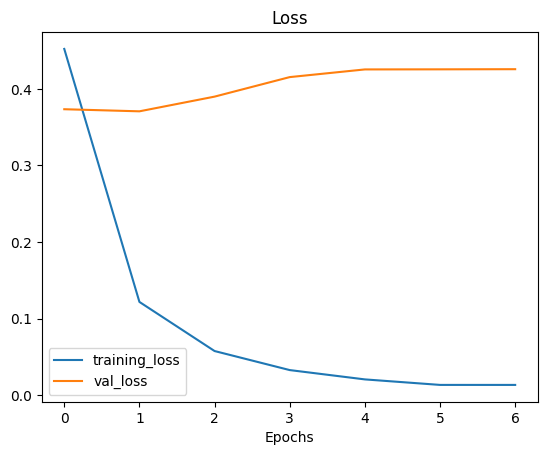

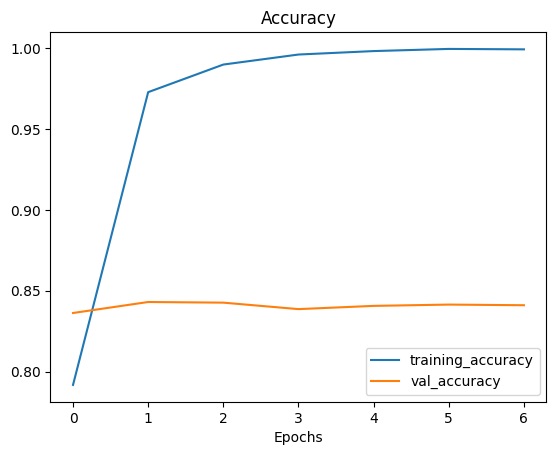

In [ ]:
plot_loss_curves(hybrid_history2)

The experiment was doomed starting on around epoch 3. Regardless of the learning rate, our experiment maxed out at 0.8418 on the validation accuracy. Let's shift the architecture in a few minor ways, add some callbacks back in and run one more time.

In [ ]:
token_inputs = layers.Input(shape=(1,), dtype="string", name="token_inputs")
token_vectors = new_text_vectorizer(token_inputs)
token_embeddings = hybrid_embedding_layer(token_vectors)
token_cnn_1 = layers.Conv1D(64, 5, 1, activation='tanh', padding='same')(token_embeddings)
token_dense_1 = layers.Dense(100, 'relu')(token_cnn_1)
token_drop_1 = layers.Dropout(0.5)(token_dense_1)
token_cnn_2 = layers.Conv1D(32, 3, 1, activation='tanh', padding='same')(token_drop_1)
token_dense_2 = layers.Dense(10, 'relu')(token_cnn_2)
token_drop_2 = layers.Dropout(0.2)(token_dense_2)
token_outputs = layers.Dense(1, 'sigmoid')(token_drop_2)
token_model = keras.Model(token_inputs, token_outputs)
token_flat = layers.Flatten()(token_model.output)

glove_inputs = layers.Input(shape=(1,), dtype="string", name="glove_inputs")
glove_vectors = new_glove_vectorizer(glove_inputs)
glove_embeddings = hybrid_embedding_layer(glove_vectors)
glove_cnn_1 = layers.Conv1D(64, 5, 1, activation='tanh', padding='same')(glove_embeddings)
glove_dense_1 = layers.Dense(100, 'relu')(glove_cnn_1)
glove_drop_1 = layers.Dropout(0.5)(glove_dense_1)
glove_cnn_2 = layers.Conv1D(32, 3, 1, activation='tanh', padding='same')(glove_drop_1)
glove_dense_2 = layers.Dense(10, 'relu')(glove_cnn_2)
glove_drop_2 = layers.Dropout(0.2)(glove_dense_2)
glove_outputs = layers.Dense(1, 'sigmoid')(glove_drop_2)
glove_model = keras.Model(glove_inputs, glove_outputs)
glove_flat = layers.Flatten()(glove_model.output)

both_embeddings = layers.Concatenate(name="hybrid_embedding")([token_flat,
                                                              glove_flat])
both_output = layers.Dense(1,'sigmoid')(both_embeddings)

model_hybrid3 = keras.Model(inputs=[token_model.input,
                                   glove_model.input],
                           outputs=both_output,
                           name="hybrid_model2")

hybrid_tb3 = create_tb_callback(TB_LOGS, model_hybrid3.name)

model_hybrid3.compile(loss=losses.BinaryCrossentropy(),
                     optimizer=optimizers.Adam(learning_rate=0.0009),
                     metrics=['accuracy'])

hybrid_history3 = model_hybrid3.fit(hybrid_train_dataset,
           epochs = 20,
           validation_data=hybrid_val_dataset,
           callbacks=[hybrid_tb3, reduce_lr_cb])

Saving TensorBoard log files to: nn_model logs/hybrid_model2/20230411, 191018
Epoch 1/20
469/469 [==============================] - 13s 23ms/step - loss: 0.2687 - accuracy: 0.8796 - val_loss: 0.3813 - val_accuracy: 0.8496 - lr: 9.0000e-04
Epoch 2/20
469/469 [==============================] - 11s 23ms/step - loss: 0.0463 - accuracy: 0.9901 - val_loss: 0.4387 - val_accuracy: 0.8466 - lr: 9.0000e-04
Epoch 3/20
469/469 [==============================] - 10s 21ms/step - loss: 0.0240 - accuracy: 0.9953 - val_loss: 0.4952 - val_accuracy: 0.8426 - lr: 9.0000e-04
Epoch 4/20
469/469 [==============================] - 11s 22ms/step - loss: 0.0160 - accuracy: 0.9975 - val_loss: 0.5274 - val_accuracy: 0.8378 - lr: 9.0000e-04
Epoch 5/20
469/469 [==============================] - 10s 22ms/step - loss: 0.0120 - accuracy: 0.9979 - val_loss: 0.5252 - val_accuracy: 0.8398 - lr: 9.0000e-07
Epoch 6/20
469/469 [==============================] - 10s 22ms/step - loss: 0.0117 - accuracy: 0.9983 - val_loss: 0.5

Not bad. Slowly increasing, but instead of spending more unnecessary time running experiments with ground-up models, let's get started with a few transfer learning experiments from TensorFlow Hub at last... 

# Implementing Transfer Learning

Let's try using the Universal Sentence Encoder (USE) pretrained model in simple Dense and CNN structures (still our best performers) and if that doesn't achieve our threshold then we will incorporate it into the hyrbid model, too.

In [ ]:
# Download the model from TF Hub
import tensorflow_hub as hub

use_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

use_embedding_layer = hub.KerasLayer(use_url,
                                    trainable=False,
                                    name="universal_sentence_encoder")

In [ ]:
# USE Dense model
inputs = layers.Input(shape=[], dtype="string")
x = use_embedding_layer(inputs)
x = layers.Dense(128, 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, 'sigmoid')(x)

use_dense = keras.Model(inputs, outputs, name="use_dense")

use_dense.compile(loss = losses.BinaryCrossentropy(),
                  optimizer = optimizers.Adam(),
                  metrics=['accuracy'])

use_dense.summary()

Model: "use_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_54 (Dense)            (None, 128)               65664     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_55 (Dense)            (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
______________________________________

In [ ]:
use_tb = create_tb_callback(TB_LOGS, use_dense.name)

use_dense = use_dense.fit(train_dataset,
           epochs = 20,
           validation_data=val_dataset,
           callbacks=[use_tb, early_stop, reduce_lr_cb])

Saving TensorBoard log files to: nn_model logs/use_dense/20230411, 191432
Epoch 1/20
469/469 [==============================] - 28s 49ms/step - loss: 0.4085 - accuracy: 0.8251 - val_loss: 0.3312 - val_accuracy: 0.8610 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - ETA: 0s - loss: 0.3361 - accuracy: 0.8564

In [ ]:
plot_loss_curves(use_dense)

We have *finally* beaten our baseline and original Dense model results - not by a whole lot, though. Now, with the USE pretrained layers incorporated, let's expand and try to reduce some minor overfitting on top of the baseline USE architecture. We are very close to breaking the 90% threshold!

In [ ]:
# Recreate Conv1D model and reduce LR
inputs = layers.Input(shape=[], dtype=tf.string)
x = use_embedding_layer(inputs)
x = layers.Reshape((1, 512))(x) # Add extra dimension to make Conv layer shape compatible
x = layers.Conv1D(64, 5, 1, activation='tanh', padding='same')(x)
x = layers.GlobalAveragePooling1D()(x)

x = layers.Dense(10, Swish())(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, 'sigmoid')(x)

use_dense_2 = keras.Model(inputs, outputs, name="use_dense_2")

use_dense_2.compile(loss = losses.BinaryCrossentropy(),
                  optimizer = optimizers.Adam(),
                  metrics=['accuracy'])

use_tb_2 = create_tb_callback(TB_LOGS, use_dense_2.name)

use_dense_2_history = use_dense_2.fit(train_dataset,
                                      epochs=20,
                                      validation_data = val_dataset,
                                      callbacks=[use_tb_2, early_stop, reduce_lr_cb])

In [ ]:
# Let's improve the USE model a bit
inputs = layers.Input(shape=[], dtype=tf.string)

# Step 1: Use a trainable embedding layer to fine-tune the input representation
x = text_vectorizer(inputs)
x = layers.Embedding(input_dim=len(words_in_vocab)+2,
                     output_dim=64,
                     mask_zero=True)(x)
x = layers.GlobalAveragePooling1D()(x)

# Step 2: Concatenate the original USE embedding with the fine-tuned embedding
use_output = use_embedding_layer(inputs)
x = layers.Concatenate()([use_output, x])

# Apply a series of dense and dropout layers
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layer
outputs = layers.Dense(1, activation='sigmoid')(x)

use_model3 = keras.Model(inputs, outputs, name="use_improved")

use_model3.compile(loss = losses.BinaryCrossentropy(),
              optimizer = optimizers.Adam(),
              metrics=['accuracy'])

use_model3_history = use_model3.fit(train_dataset,
                                      epochs=20,
                                      validation_data = val_dataset,
                                      callbacks=[use_tb_2, reduce_lr_cb])

It looks like we're still getting stuck in a local minimum somewhere along the way. We've done over 20 different modelling experiments and attempting all of the different methods indicated at the beginning of the document. If we wanted to continue, a potential next experiment might be to implement the BERT model (as below), also using transfer learning. Unfortunately, we've fallen just short of our threshold of 90%, reaching 87% accuracy with our best performing model.

In [ ]:
# Load the pre-trained BERT model
bert_layer = hub.KerasLayer("https://tfhub.dev/google/experts/bert/wiki_books/2",
                            trainable=True)

# [ **Thank You** ]